In [1]:
%matplotlib notebook
import math
import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt

import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit
import scipy.ndimage as rnoise

import scipy.stats as stats
from scipy.optimize import curve_fit

# Theory

* I defined $d_{new}$ as $d_{new} = nd_{old}$as 

$$d_{new}=nd_{old} = n \left[\frac{2c}{h_+} \left( \frac{G \mathcal{M}}{c^3}\right)^{5/3} \Omega^{\frac{2}{3}}(t) \left(1+cos^2i\right) cos2\Phi(t)\right]$$ 

where $n$ can be defined as the ratio of a reference luminosity distance to the actual luminiosty distance: 

$$n = \frac{d_L}{d_0} = \frac{d_{old}}{d_{actual}}$$

* $d_{old}$ is the distnace caclulatued using the unconstrained distnace calculator and $d_{actual}$ is the luminosity distance estimated by LIGO. 

* I was reading around and found an equation that relates the amplitude of the GW signal ($\mathcal{A}_{+}$) and the inclination angle ($i$)

$$\mathcal{A_{+}}=h_{+}= \frac{d_0}{d_L}\frac{1+cos^2i}{2} \rightarrow \left(1+cos^2i\right) = \frac{2d_Lh_{+}}{d_0}$$


* Now the amplitude equation looks like: 

$$h_+ = \frac{1+cos^2i}{2n}$$

* solving this equation for $cos^2i$ and taking the inverse cos we see that the inclination angle i is equal to 

$$cos^2i = 2nh_+ - 1 \rightarrow \boxed{i \approx \sqrt{|{2nh_+ -1}|} + 2 \pi k}$$

* The expression above implies some kind of relation between the inclination angle, the maximum strain of the gravitational wave, and the ratio of the actual luminosity distance to a reference luminosity distance


* I am currently playing with the idea that this inclination angle degreneracy may be due to the binary system precessing, consequentually obscuring accurate strain data, thus impededing upon our ability to accurately determine a distance and inclination angle according to the observed strain data. 

# Data

In [5]:
waves = {'GW190521': 'H-H1_GWOSC_16KHZ_R2-1242442952-32.txt', 
         'GW190814': 'H-H1_GWOSC_16KHZ_R1-1249852241-32.txt',
         'GW190412': 'H-H1_GWOSC_16KHZ_R2-1239082247-32.txt',
         'GW190425': 'L-L1_GWOSC_16KHZ_R1-1240215487-32.txt', # L1 obs
         'GW170817': 'H-H1_GWOSC_16KHZ_R1-1187008867-32.txt',
         'GW170814': 'H-H1_GWOSC_16KHZ_R1-1186741846-32.txt',
         'GW170608': 'H-H1_GWOSC_16KHZ_R1-1180922479-32.txt',
         'GW170104': 'H-H1_GWOSC_16KHZ_R1-1167559921-32.txt',
         'GW151226': 'H-H1_GWOSC_16KHZ_R1-1135136335-32.txt'
        }
#'GW150914': 'H-H1_GWOSC_16KHZ_R1-1126259447-32.txt' -- the file I don't have

In [6]:
def find_strain(filename):
    '''
    Arg: filename, str. 
    Returns: max_strain, float.
    '''
    df = pd.read_csv(filename, dtype = str, names = ['strain'])
    df = df.drop(labels = [0,1,2], axis = 0).astype(float)
    max_s = df['strain'].max()
    return max_s

In [7]:
for i in waves:
    find_strain(waves[i])

In [8]:
GW190521_tbl = Table.read(GW190521, format='ascii')
GW190814_tbl = Table.read(GW190814, format='ascii')
GW190412_tbl = Table.read(GW190412, format='ascii')

NameError: name 'GW190521' is not defined

In [15]:
GW190425_tbl = Table.read(GW190425, format='ascii') # L1 obs
GW170817_tbl = Table.read(GW170817, format='ascii')
GW170814_tbl = Table.read(GW170814, format='ascii')

In [16]:
GW170608_tbl = Table.read(GW170608, format='ascii')
GW170104_tbl = Table.read(GW170104, format='ascii')
GW151226_tbl = Table.read(GW151226, format='ascii')
GW150914_tbl = Table.read(GW150914, format='ascii')

In [17]:
GW190521_strain = GW190521_tbl['-6.9973189495553901e-21']
GW190814_strain = GW190814_tbl['-3.0160263673448252e-20']
GW190412_strain = GW190412_tbl['-4.4230383945296193e-19']
GW190425_strain = GW190425_tbl['-5.5244482372502713e-20'] # L1 obs
GW170817_strain = GW170817_tbl['5.8751133791669278e-19'] # kilanova 
GW170814_strain = GW170814_tbl['-7.6681619209110251e-19']
GW170608_strain = GW170608_tbl['1.6421373582598675e-20']
GW170104_strain = GW170104_tbl['-2.9550085672987675e-19']
GW151226_strain = GW151226_tbl['2.7996600287459531e-20']
GW150914_strain = GW150914_tbl['6.0951345581611108e-21']

# Functions

In [18]:
def distance_to_GW(t, M_sol, h_max, i):
    '''This function will give the non-localized distance (in Mpc) to the gravitational wave 
    when inputting time in seconds, combined mass (or chirp mass) in solar masses, and the maximum strain in Hz.'''
    
    G = 6.67e-11 # N kg^-2 m^2
    c = 3e8 # m/s
    
    M = M_sol * (2 * 10**30) # gives mass in kg
    
    term1 = (5/256)**(3/8)
    term2 = ((c**3) / (G * M))**(5/8)
    term3 = (1 / (t**(3/8)))
    term4 = (t**(5/8))
    
    orbital_freq = term1 * term2 * term3
    orbital_phase = np.round(0.36571582 * term2 * term4) #round terms to third sig fig, round the constant to third sig fig
    
    distance = (2*c / h_max) * (G*M / (c**3))**(5/3) * orbital_freq**(2/3) *(1 + np.cos(i)**2)* abs(np.cos(2 * orbital_phase)) # this is distance in meters
    
    #print(orbital_freq) # printed this just to check the value of it
    #print(orbital_phase) # printed this just to check the value of it
    #print(orbital_freq)
    #print(orbital_phase)
    return distance / (9.223 * 10**18)#i returns distance in Mpc. 2.25 update: change [distance / (9.223 * 10**18), i]
    # distance only, for debugging best_i_arr. If anyone need to use best_angle again, please change the return statement to the original one

In [19]:
def best_i(actual_dis, f): # a helper function for best_i_arr, does similar things as best_angle
    angle_lst = np.arange(0, math.pi , 0.001)
    best_dif = float('inf')
    best_i = 0
    for i in range(len(angle_lst)):
        d = f(angle_lst[i])
        
        #print('---')
        #print(str(angle_lst[i])+' | ' + str(d))
        if abs(d - actual_dis) < best_dif:
            best_i = angle_lst[i]
            best_dif = abs(d - actual_dis)
            
            
            #print(best_dif)
            #print('---')
    #print('Best i: ' + str(best_i))

    return best_i

def best_i_arr(actual_arr, t_arr, chirp_mass_arr, h_max_arr): # give it arrays of: actual distance, time, h_max, and chirp_mass
    i_array = []
    f_arr = []  #a helper function array that returns gw_distance but only need to input angle i
    for n in range(len(t_arr)):
        f_arr.append(lambda x: distance_to_GW(t_arr[n],chirp_mass_arr[n], h_max_arr[n], x))

    for m in range(len(f_arr)):
        i_array.append(best_i(actual_arr[m], f_arr[m]))
       # print(best_i(actual_arr[m], f_arr[m]))

    return i_array

def gw_dis_array(t_arr, chirp_mass_arr, h_max_arr, i_arr):
    ret = []
    for i in range(len(t_arr)):
        ret.append(distance_to_GW(t_arr[i], chirp_mass_arr[i], h_max_arr[i], i_arr[i]))
    return ret

In [20]:
def max_strain(strain_arr):
    max_str = [] 
    for i in np.arange(len(strain_arr)):
        max_str.append(max(abs(strain_arr[i])))
    return max_str

In [21]:
def best_distance(lum_dist, times, masses, max_str):
    
    #logistics
    #assert len(lum_dist) == len(times) == len(masses) == len(max_str) == 10
    lum_dist = np.array(lum_dist)
    masses = np.array(masses)
    times = np.array(times)
    max_str = np.array(max_str)
    
    #calc
    distance_and_angles = []
    for i in np.arange(len(times)):
        d = [] #shape = (2, 90)
        for angle in np.arange(0, np.pi/2, 0.01):
            distance = distance_to_GW(times[i], masses[i], max_str[i], angle)
            dist_for_angle = np.array([distance, angle])
            #print(dist_for_angle)
            d.append(dist_for_angle)
        ith_dist_angle = best_result(d, lum_dist[i])
        distance_and_angles.append(ith_dist_angle)
        
    return distance_and_angles


def best_result(distances, lum_dist):
    '''Computes the best angle by minimizing the distances calculated to the actual distance'''
    best_difference = float('inf')
    best_angle = 0
    
    for i in distances: 
        
        best_d = abs(i[0] - lum_dist) #i[0] = estimated distance
        #print(i[0])
        if best_d < best_difference:
            best_difference = best_d
            best_arr = i
            #print(i)
    return best_arr

In [22]:
def fix_inc_og(lum_dist, times, mass, max_strain, file_name):
    
    d_new = []
    
    for x in np.arange(len(times)):
        n = 1
        inc = best_i(lum_dist[x], lambda i: distance_to_GW(times[x], mass[x], max_strain[x],i)) # OG inc
        d_old = distance_to_GW(times[x], mass[x], max_strain[x],inc)
        #print('iteration: ' + str(x))
        
        while n < 11: 
            if inc == 0:   # check current inc
                n+=1
                
                # Finding the best inc via the old n guessing method
                inc = best_i(lum_dist[x], lambda i: distance_to_GW(times[x], mass[x], max_strain[x],i)*n) # reclac inc if wrong
                
            elif inc != 0: 
                
                # guessing d via old n method (for loop fitting)    
                d = distance_to_GW(times[x], mass[x], max_strain[x],inc)*n # recalc dist
                
                # guessing n and d according to d_old/d_act ratio
                n_guess = d_old/d
                
                if np.round(n_guess,4) == 0.9999:
                    n_guess = np.round(n_guess)
                elif np.round(n_guess,1) == 0.1: 
                    n_guess = 9
                elif np.round(n_guess,1) != 0.1 and np.round(n_guess,4) != 0.9999: 
                    n_guess = np.round(n_guess*10)-1
                
                d_guess = distance_to_GW(times[x], mass[x], max_strain[x],inc)*n_guess   
                
                # Print Statments to check results
                print(file_name[x] + ':')
                print('--------')
                
                print('i_new ~ ' + str(np.round(np.rad2deg(inc))) + '° | ' + 'n_actual = ' + str(n) + ' | n_guess = ' + 
                     str(n_guess))
                
                print('D_old = ' + str(np.round(d_old,5)) + ' Mpc')
                print('D_new = ' + str(np.round(d,5)) + ' Mpc')
                print('D_guess = ' + str(np.round(d_guess, 5)) + ' Mpc')
                print('D_actual = ' + str(lum_dist[x]) + ' Mpc')
                print('Error: ' + str(np.round(abs(lum_dist[x]-np.round(d,5))/lum_dist[x]*100,3)) + '%')
                print('')
                d_new.append([d,inc, n])
                
                break    
    return d_new

In [23]:
def fix_inc_new(lum_dist, times, mass, max_strain, file_name):
    
    d_new = []
    
    for x in np.arange(len(times)):
        # Calculate distance and inc using standard method 
        
        inc = best_i(lum_dist[x], lambda i: distance_to_GW(times[x], mass[x], max_strain[x],i)) # OG inc
        d_old = distance_to_GW(times[x], mass[x], max_strain[x],inc)
        
        # Determine the n value 
        
        n_guess = d_old/ld[x]  # values in Mpc: develop better argument for n_guess
        if np.round(n_guess,4) == 0.9999:
            n_guess = np.round(n_guess) 
        elif np.round(n_guess,1) == 0.1: 
            n_guess = 9
        elif np.round(n_guess,1) != 0.1 and np.round(n_guess,4) != 0.9999: 
            n_guess = np.round(n_guess*10)-1
            
        # Recalculate the distance and inc
        inc_new = best_i(lum_dist[x], lambda i: distance_to_GW(times[x], mass[x], max_strain[x],i)*n_guess)
        d_guess = distance_to_GW(times[x], mass[x], max_strain[x],inc_new)*n_guess   
                
        # Print Statments to check results
        print(file_name[x] + ':')
        print('--------')
        print('Iteration: ' + str(x))
        print('i_new ~ ' + str(np.round(np.rad2deg(inc_new))) + '° | n_guess = ' + str(n_guess))
        print('D_guess = ' + str(np.round(d_guess, 5)) + ' Mpc')
        print('D_actual = ' + str(lum_dist[x]) + ' Mpc')
        print('Error: ' + str(np.round(abs(lum_dist[x]-np.round(d_guess,5))/lum_dist[x]*100,3)) + '%')
        print('')
        
        d_new.append([d_guess,inc_new, n_guess])
    return d_new

In [24]:
def vel(dist, H0):
    return H0*dist

In [25]:
# guess n procedure 

def guess_n(lum_dist, times, mass, max_strain):
    # guess the n value 
    
    n_new = []
    for x in np.arange(len(times)):
        
        # Determine d_old and inc_old
        inc_old = best_i(lum_dist[x], lambda i: distance_to_GW(times[x], mass[x], max_strain[x],i)) # OG inc
        d_old = distance_to_GW(times[x], mass[x], max_strain[x],inc_old)
        
        # Determine the n_guess  
        n_guess = d_old/ld[x]  # D values in Mpc
        if np.round(n_guess,4) == 0.9999:
            n_guess = np.round(n_guess) 
        elif np.round(n_guess,1) == 0.1: # could be a constraint on n 
            n_guess = 9 # try changing this to 1 or 9 and see what happens...9works best
        elif np.round(n_guess,1) != 0.1 and np.round(n_guess,4) != 0.9999: 
            n_guess = np.round(n_guess*10)-1
        
        #print('n_guess = ' + str(n_guess))
        n_new.append(n_guess)
  
    return n_new

In [26]:
# Guess inc procedure 

def inc_calc(lum_dist, times, mass, max_strain, n_new):
    # use n_guess to create array of inc values to test 
    
    inc_arr = []
    k_rng = np.arange(0,2,0.001) # create range of k values to test
    
    for x in np.arange(len(times)): 
        i_arr = []
        
        for k in k_rng:
            i = np.arccos(np.sqrt(abs((2*max_strain[x]*n_new[x])-1))) + (2*np.pi*k)
            i_arr.append(np.round(i,3))
        
        ind = np.where(np.array(i_arr) <= np.pi)
        ind = ind[0].astype(int)
        inc_arr.append(np.array(i_arr)[ind])
    
    
    return inc_arr

In [27]:
# Get new distance and inclination angle for all target inc values 

def tgt_val_calc(lum_dist, times, mass, max_strain, n_new, inc_new): 
    # returns target distance and inc values for array of incs from inc_calc 
    dist_arr = []
    
    for x in np.arange(len(times)):
        incs = inc_new[x]
        dists = []
        
        for ind in np.arange(len(incs)):
            d = distance_to_GW(times[x], mass[x], max_strain[x],incs[ind])*n_new[x]
            dists.append(d)
            
        dist_arr.append(dists)
    return dist_arr

In [28]:
def target_acq(d_new, lum_dist, inc_new):
    # filter dist and inc arrays to values that are close to d_actual
    d_tgt = []
    inc_tgt = []
    for x in np.arange(len(lum_dist)):
        target = np.isclose(d_new[x], lum_dist[x], atol = 0.2, rtol = 1e-2)
        target_inds = np.where(target == True)
        d_tgt.append(np.array(d_new[x])[target_inds[0]])
        inc_tgt.append(np.array(inc_new[x])[target_inds[0]])
    return d_tgt, inc_tgt

In [29]:
def error_calc(d_tgt, inc_tgt, lum_dist):
    # return the error for each target dist and inc value
    error_arr = []
    for x in np.arange(len(ld)):
        error = []
        for d in d_tgt[x]:
            err = abs(d - ld[x])/ld[x] * 100
            error.append(err)
        error_arr.append(error)
    return error_arr

In [30]:
def guess_results(error_arr, lum_dist, d_tgt, inc_tgt):
    restult_arr = []
    
    for x in np.arange(len(lum_dist)):
        if len(error_arr[x]) == 0:
            restult_arr.append(0)
        elif len(error_arr[x]) != 0:
            tgt_ind = np.where(error_arr[x] == min(error_arr[x]))
            tgt_ind = tgt_ind[0].astype(int)
            
            d = d_tgt[x][tgt_ind[0]]
            i = inc_tgt[x][tgt_ind[0]]
            restult_arr.append([d, i, min(error_arr[x])])
    return restult_arr

In [31]:
def GW_caclulator(lum_dist, times, mass, max_strain, z, GW_names, num_of_mdls, plot_res=False, plot_chi=False, prt=False):
    
    # determine n_guess
    n_guess = guess_n(lum_dist, times, mass, max_strain)
    
    # determine inc_new
    inc_new = inc_calc(lum_dist, times, mass, max_strain, n_guess)
    
    # determine d_new
    d_new = tgt_val_calc(lum_dist, times, mass, max_strain, n_guess, inc_new)
    
    # Determine target distance values 
    target = target_acq(d_new, lum_dist, inc_new)
    
    # Determine the errors of d_new
    error_arr = error_calc(target[0], target[1], lum_dist)
    
    # Determine target values 
    r_check = guess_results(error_arr, lum_dist, target[0], target[1])
    
    # Find best target values by checking errors and results 
    
    distances = []
    inclinations = []
    inc_new_arr = []
    errors = []
    GW_name_gd = []
    z_new = []

    for x in np.arange(len(ld)):
        results = np.array(r_check[x])
        
        if results.all() == 0: 
            #distances.append(np.nan)
            continue
        elif results.all() != 0:
            d = results[0]
            inc = results[1]
            err = results[2]
            distances.append(d)
            inclinations.append(inc)
            errors.append(err)
            GW_name_gd.append(GW_names[x])
            inc_new_arr.append(inc)
            z_new.append(z_act[x])
    
    # Find v
    c = 3e+5 # km/s
    v = np.array(sorted(z_new)).astype(float)*c
    
    GW_names_gd_sorted = [GW_name_gd[2], GW_name_gd[1], GW_name_gd[3], GW_name_gd[5], GW_name_gd[4], GW_name_gd[0]]
    errors_sorted = [errors[2], errors[1], errors[3], errors[5], errors[4], errors[0]]
    distances_sorted = sorted(distances)
    
    incs_sorted = [inc_new_arr[2], inc_new_arr[1], inc_new_arr[3], inc_new_arr[5], inc_new_arr[0]]
    
    v_sorted = sorted(v) #km/s
    
    #Find the fitted line
    xfit = np.linspace(distances_sorted[0], distances_sorted[4], num=len(distances_sorted[:4]))
    coeffs = poly.polyfit(distances_sorted[:4],v_sorted[:4], 1)
    yfit = poly.polyval(xfit,coeffs)     
    
    # Chi^2 test
    p,cove = curve_fit(vel,xfit, yfit, 72)
    h0_int = p[0]

    sig_h0 = np.sqrt(cove[0][0])

    h0_tst = np.linspace(h0_int - 200*sig_h0, h0_int+200*sig_h0, num = num_of_mdls) # 200 sigma interval

    h0_chi_min = []

    for i in np.arange(4): # loops through 100000 h0_tst values, 4 times, to generate 100 models for all 4 GW target distances
        chi_min = []
        for h in h0_tst: 
            chi_min.append(chi_sqrt(np.array(v_sorted[i]), vel(distances_sorted[i], h)))
        h0_chi_min.append(chi_min)

    min_inds = []
    for i in np.arange(4):
        min_ind = np.where(h0_chi_min == min(h0_chi_min[i]))[1][0]
        min_inds.append(min_ind)
        
    h0_tst2 = np.linspace(min(h0_tst[min_inds])-20, (max(h0_tst[min_inds]))+20, num = num_of_mdls) # test around 60-80 since chi_min reaches min for 4 signals between this bound

    h0_chi_min2 = []

    for i in np.arange(4): # loops through 100000 h0_tst values, 4 times, to generate 100 models for all 4 GW target distances
        chi_min2 = []
        for h in h0_tst2: 
            chi_min2.append(chi_sqrt(np.array(v_sorted[i]), vel(distances_sorted[i], h)))
        h0_chi_min2.append(chi_min2)

    min_inds2 = []
    for i in np.arange(4):
        min_ind2 = np.where(h0_chi_min2 == min(h0_chi_min2[i]))[1][0]
        min_inds2.append(min_ind2)

    # Determine H0 from min chi^2
    pf,covef = curve_fit(vel,xfit, yfit, np.mean(h0_tst2[min_inds2]))
    h0f = np.mean(h0_tst2[min_inds2])
    covar = covef[0][0]
        
    if plot_chi == True:
        fig, (ax1,ax2) = plt.subplots(2,2, figsize=(10,5))
        fig.suptitle(r'$\chi^2$ G.O.F. Test on $H_0$')
        ax1[0].plot(h0_tst2, h0_chi_min2[0], label = GW_names_gd_sorted[0])
        ax1[1].plot(h0_tst2, h0_chi_min2[1], label = GW_names_gd_sorted[1])
        ax2[0].plot(h0_tst2, h0_chi_min2[2], label = GW_names_gd_sorted[2])
        ax2[1]. plot(h0_tst2, h0_chi_min2[3], label = GW_names_gd_sorted[3])
        for ax in ax1:
            ax.set(xlabel='$H_{0,tst}$', ylabel='$\chi^2$')
        for ax in ax2:
            ax.set(xlabel='$H_{0,tst}$', ylabel='$\chi^2$')
        ax1[0].grid()
        ax1[1].grid()
        ax2[0].grid()
        ax2[1].grid()
        ax1[0].legend()
        ax1[1].legend()
        ax2[0].legend()
        ax2[1].legend()
        plt.show()
        
    if plot_res == True: 
        plt.figure(figsize=(10,5))
        plt.plot(xfit, yfit, label = 'Fitted Line (Function)', color = 'k', linestyle = '--')
        plt.errorbar(distances_sorted[:4], v_sorted[:4], xerr = distances_sorted[:4] - xfit, yerr = v_sorted[:4] - yfit, 
                     color = 'r', label = 'Data w/ Error Bars', fmt = 'o')
        plt.title('H0 Plot from Final Algorithm')
        plt.ylabel('Velocity [km/s]')
        plt.xlabel('Distance [Mpc]')
        plt.legend()
        plt.grid()
        plt.show()
        
    if prt == True:
        for x in np.arange(len(distances_sorted[:4])):
            print(GW_names_gd_sorted[x])
            print('-------------------')
            print('D_guess ≈ ' + str(distances_sorted[x]) + 'Mpc')
            print('i_guess ≈ ' + str(incs_sorted[x]) + ' rad, ' + str(np.round(np.rad2deg(incs_sorted[x]))) + '°')
            print('z ≈ ' + str(z_new[x]))
            print('H0_estimate ≈ ' + str(h0_tst2[min_inds2[x]]) + ' km/s/Mpc')
            print('')
            
        '''print(' ')
        print('H0 Estimate: Final Results')
        print('------------------------')
        print('H0_actual ≈ 72 km/s/Mpc')
        print('H0_estimated ~ ' + str((np.round(np.mean(h0_tst2[min_inds2]),6))) + ' ± ' + str(covar)  + ' km/s/Mpc')
        print('Absolute Error ~ ' + str(np.round(abs(np.mean(h0_tst2[min_inds2])-72)/72 *100, 6)) + '%')'''
    
    return distances_sorted[:4], v_sorted[:4],xfit, yfit, incs_sorted[:4], errors_sorted[:4], z_new[:4], GW_names_gd_sorted[:4], h0_tst2, h0_chi_min2, h0f, covar, h0_tst2[min_inds2], h0_int, sig_h0

In [32]:
def chi_sqrt(data, model, error=1): 
    return (np.sum((data-model)**2 / error**2))

# Final Algorithm

In [33]:
# Input Arrays for best_distances
GW_name = ['GW190521', 'GW190814', 'GW190412', 'GW190425','GW170817 (kilanova)',  'GW170814', 
          'GW170608', 'GW170104', 'GW151226', 'GW150914']

ld = [5300, 241, 740, 159, 40, 600, 320, 990, 450, 440] # Mpc
ld_up_err = [2400, 41, 130, 69, 7, 150, 120, 440, 180, 150] # Mpc
ld_dn_err = [2600, 45, 160, 71, 15, 220, 110, 430, 190, 170] # Mpc

time = [32, 32, 32, 32, 32, 32, 32, 32, 32, 32] # s

mass = [150, 25.8, 38.4, 3.4, 2.8, 53.2, 17.8, 48.9, 20.5, 63.1] # M_sol
mass_up_err = [29,1, 3.8, 0.3, 0, 3.2, 3.4, 5.1, 6.4, 3.4] # M_sol
mass_dn_err = [17, 0.9, 3.9, 0.1, 0, 2.4, 0.7, 4.0, 1.5, 3.0] # M_sol

z_act = [0.82, 0.053, 0.15, 0.03, 0.01, 0.12, 0.07, 0.20, 0.09, 0.09] # kila nova has 0 error in z
z_up_err = [0.28, 0.009, 0.03, 0.01, 0, 0.03, 0.02, 0.08, 0.04, 0.03]
z_dn_err = [0.34, 0.010, 0.03, 0.02, 0, 0.04, 0.02, 0.08, 0.04, 0.03]

str_arr = [np.array(GW190521_strain), np.array(GW190814_strain), np.array(GW190412_strain),
          np.array(GW190425_strain), np.array(GW170817_strain), np.array(GW170814_strain),
           np.array(GW170608_strain), np.array(GW170104_strain), np.array(GW151226_strain), np.array(GW150914_strain)]

strain_max = max_strain(str_arr)


ld_ulim = []
ld_llim = [] 

mass_ulim = []
mass_llim = []

z_ulim_act = []
z_llim_act = []

for i in np.arange(len(ld)):
    d_ulim = ld[i] + ld_up_err[i]
    d_llim = ld[i] - ld_dn_err[i]
    
    m_ulim = mass[i] + mass_up_err[i]
    m_llim = mass[i] - mass_dn_err[i]
    
    z_ulim = z_act[i] + z_up_err[i]
    z_llim = z_act[i] - z_dn_err[i]
    
    ld_ulim.append(d_ulim)
    ld_llim.append(d_llim)
    
    mass_ulim.append(m_ulim)
    mass_llim.append(m_llim)
    
    z_ulim_act.append(z_ulim)
    z_llim_act.append(z_llim)
    
tst = best_distance(np.array(ld), np.array(time), np.array(mass), np.array(strain_max))
tst_ulim = best_distance(np.array(ld_ulim), np.array(time), np.array(mass_ulim), np.array(strain_max))
tst_llim = best_distance(np.array(ld_llim), np.array(time), np.array(mass_llim), np.array(strain_max))

distances = []
distances_ulim = []
distances_llim = []

for i in np.arange(len(time)):
    distances.append(tst[i][0])
    distances_ulim.append(tst_ulim[i][0])
    distances_llim.append(tst_llim[i][0])

<IPython.core.display.Javascript object>


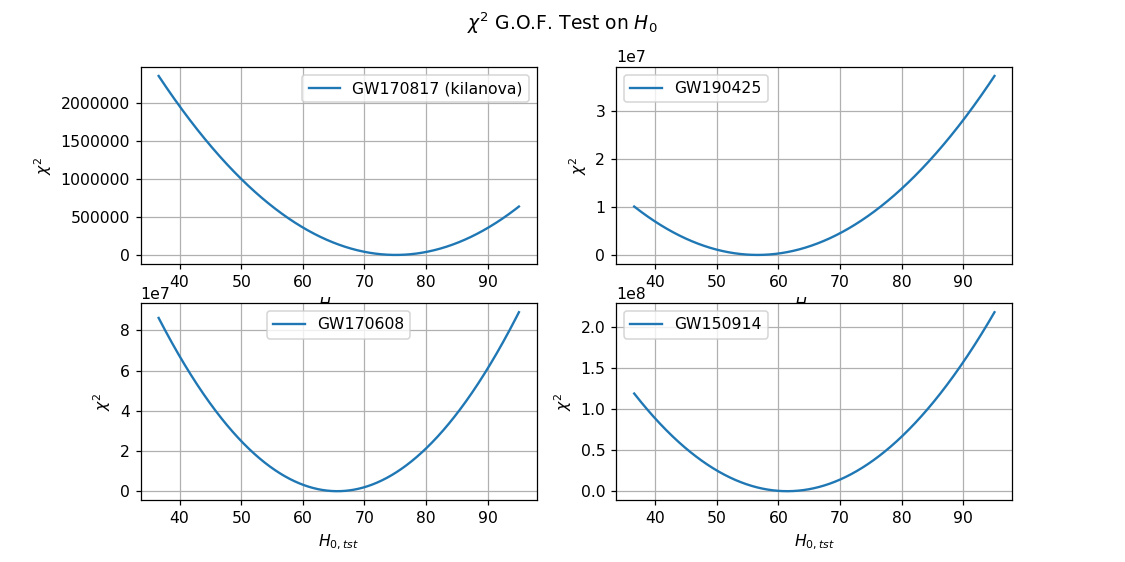

<IPython.core.display.Javascript object>


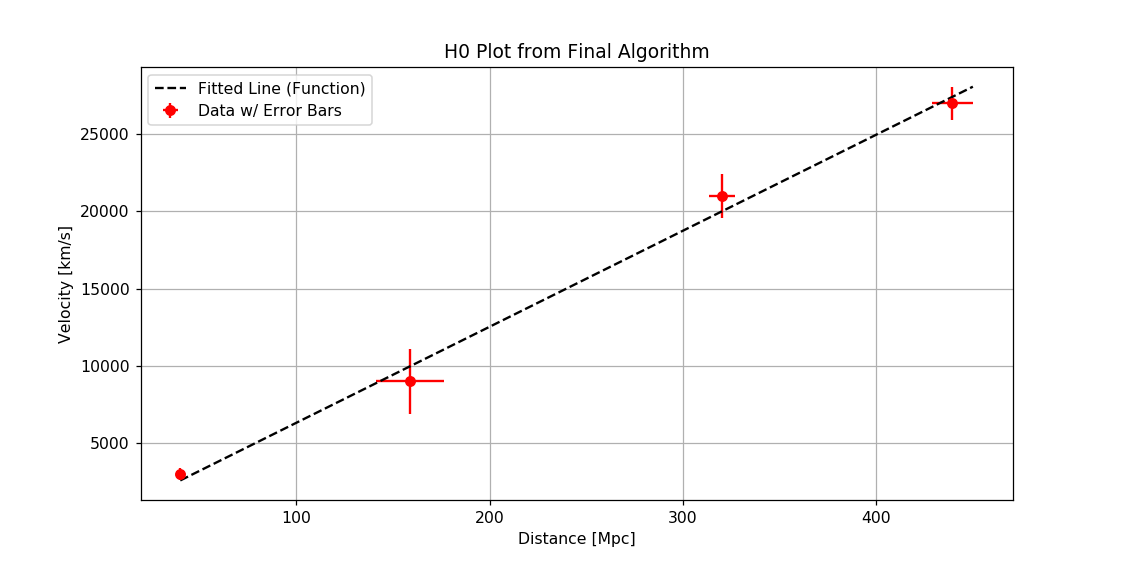

GW170817 (kilanova)
-------------------
D_guess ≈ 39.9664507149934Mpc
i_guess ≈ 2.652 rad, 152.0°
z ≈ 0.82
H0_estimate ≈ 75.06295098264923 km/s/Mpc

GW190425
-------------------
D_guess ≈ 159.00133444218054Mpc
i_guess ≈ 3.054 rad, 175.0°
z ≈ 0.03
H0_estimate ≈ 56.60331151802502 km/s/Mpc

GW170608
-------------------
D_guess ≈ 320.1450646766827Mpc
i_guess ≈ 0.528 rad, 30.0°
z ≈ 0.01
H0_estimate ≈ 65.59528802048149 km/s/Mpc

GW150914
-------------------
D_guess ≈ 439.46027446545526Mpc
i_guess ≈ 1.225 rad, 70.0°
z ≈ 0.07
H0_estimate ≈ 61.43897977099252 km/s/Mpc



In [34]:
alg = GW_caclulator(ld, time, mass, strain_max, z_act, GW_name, 1000000, plot_res=True, plot_chi=True, prt=True)

In [35]:
alg[-1], alg[13] + 200*alg[-1],  alg[13] - 100*alg[-1]

(0.12757511218650594, 87.95921950355935, 49.68668584760757)

In [36]:
# return distances_sorted[:4], v_sorted[:4],xfit, yfit, incs_sorted[:4], errors_sorted[:4]
# , z_new[:4], GW_names_gd_sorted[:4], h0_tst2, h0_chi_min2, h0f, covar, h0_tst2[min_inds2], r_check

np.where(alg[9][3] == (min(alg[9][3])))[0][0], min(alg[9][3]) , 
np.where(np.isclose(alg[9][3], alg[9][3][np.where(alg[9][3] == (min(alg[9][3])))[0][0]] +1, atol = .11) == True)[0][0]

424794

In [37]:
chimin_inds = []
print('Indices of chi^2_min +1')
print('-----------------------')
for y in np.arange(4):
    ind = np.where(np.isclose(alg[9][y], 
                              alg[9][y][np.where(alg[9][y] == (min(alg[9][y])))[0][0]]+2, atol = .0222) == True)[0]
    chimin_inds.append(ind)
    
chimin_inds

Indices of chi^2_min +1
-----------------------


[array([657275, 657276, 657277, 657278, 657279, 657280, 657281, 658486,
        658487, 658488, 658489, 658490, 658491], dtype=int64),
 array([341963, 341964, 342268], dtype=int64),
 array([495855, 496006], dtype=int64),
 array([424779], dtype=int64)]

In [38]:
x = 0
test = alg[9] 

best_inds = []
for x in np.arange(4):
    best_ind = (np.where((np.array(test[x])[chimin_inds[x].astype(int)] == 
              min(np.array(test[x])[chimin_inds[x].astype(int)])) == True)[0][0])
    best_inds.append(chimin_inds[x][best_ind])
    
best_inds

[657281, 341964, 496006, 424779]

In [39]:
# Chi_min for H0_1 

alg[9][0][best_inds[0]], alg[9][1][best_inds[1]], alg[9][2][best_inds[2]], alg[9][3][best_inds[3]]

(1.9790793813436804, 1.990357545308701, 1.992033824285089, 2.0223000855803717)

In [40]:
# H0_1
alg[8][best_inds[0]], alg[8][best_inds[1]], alg[8][best_inds[2]], alg[8][best_inds[3]] 

(75.02775825206717, 56.59442564585148, 65.59967249688292, 61.43576448829814)

In [41]:
#H0_min
alg[12]

array([75.06295098, 56.60331152, 65.59528802, 61.43897977])

In [42]:
# finding the uncertanity in H0_min

abs(alg[12][0] - alg[8][best_inds[0]]),abs(alg[12][1] - alg[8][best_inds[1]]), abs(alg[12][2] - alg[8][best_inds[2]]),abs(alg[12][3] - alg[8][best_inds[3]] )

(0.035192730582053855,
 0.008885872173543419,
 0.004384476401426696,
 0.0032152826943772084)

In [43]:
# Finding sigma^2
abs(alg[12][0] - alg[8][best_inds[0]])**2,abs(alg[12][1] - alg[8][best_inds[1]])**2, abs(alg[12][2] - alg[8][best_inds[2]])**2,abs(alg[12][3] - alg[8][best_inds[3]])**2

(0.0012385282858210288,
 7.895872428455324e-05,
 1.9223633314667587e-05,
 1.0338042804761561e-05)

In [44]:
h0_1 = []
for x in np.arange(4):
    h0_1.append(alg[8][best_inds[x]])

sig_i = []
for x in np.arange(4):
    sig_i.append((alg[12][x] - h0_1[x])**2)    
h0_1, sig_i

([75.02775825206717, 56.59442564585148, 65.59967249688292, 61.43576448829814],
 [0.0012385282858210288,
  7.895872428455324e-05,
  1.9223633314667587e-05,
  1.0338042804761561e-05])

In [45]:
H0_act = (np.sum(np.array(alg[12])/np.array(sig_i))) / (np.sum(1/np.array(sig_i)))
uncertanity = 1 / (np.sum(1/np.array(sig_i)))
uncertanity, H0_act, H0_act + uncertanity,  H0_act - uncertanity

(6.164404705072089e-06,
 62.46205764808898,
 62.46206381249368,
 62.46205148368428)

# Discussion

the slope of the model is around 62...just just the raw H0 estimate  and the chi_min test looks for H0 for each of the 4 cases and then comapares that to the fitted line...which has a slope of H0~62 so yes these results and uncertanities are accurate for the model I have...i might make another model with the verified H0 value of ~73 and see what happens there but for now our final results stand with H0 = 62.46+/- 6.1e-6

In [304]:
# sig in chi_2_min = uncertanity on each H0 data point

# Sig in H0_mean = H0_act is uncertanity in H0 